In [1]:
from IPython.core.display import display, HTML
from matplotlib.pyplot import rc
display(HTML("<style>.container { width:100% !important; }</style>"))
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : '12'}
rc('font', **font)  # pass in the font dict as kwargs

In [2]:
from qiskit import IBMQ
mytoken = '105ccb14a9f37cd5ce743b6e47f48c0da24790f0432159de03b522fa68d16848eb741951dcbe5f2aa0af2e0ce3abd5be008d9e37042da2b95e83dbef772850f0'
IBMQ.save_account(mytoken, overwrite=True)

In [3]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from matplotlib import pyplot as plt
import qiskit.providers.aer.noise as noise
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
for backend in provider.backends():
    print(backend)

ibmq_qasm_simulator
ibmq_armonk
ibmq_santiago
ibmq_bogota
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila


In [4]:
from qiskit.extensions import UnitaryGate
sqrtX = UnitaryGate([[1/np.sqrt(2), -1/np.sqrt(2)*1j], [-1/np.sqrt(2)*1j, 1/np.sqrt(2)]], label='X^1/2')
sqrtY = UnitaryGate([[1/np.sqrt(2), -1/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)]], label='Y^1/2')
sqrtW = UnitaryGate([[1/np.sqrt(2), -1/np.sqrt(2)*np.sqrt(1j)], [1/np.sqrt(2)*np.sqrt(-1j), 1/np.sqrt(2)]], label='W^1/2')

In [5]:
# exploring gate sqrtX
qc = QuantumCircuit(3)
qc.append(sqrtX, [0])
qc.draw()

┌───────┐
q_0: ┤ X^1/2 ├
     └───────┘
q_1: ─────────
              
q_2: ─────────

In [6]:
# exploring gate sqrtY
qc = QuantumCircuit(3)
qc.append(sqrtY, [1])
qc.draw()

q_0: ─────────
     ┌───────┐
q_1: ┤ Y^1/2 ├
     └───────┘
q_2: ─────────

In [7]:
# exploring gate sqrtW
qc = QuantumCircuit(3)
qc.append(sqrtW, [2])
qc.draw()

q_0: ─────────
              
q_1: ─────────
     ┌───────┐
q_2: ┤ W^1/2 ├
     └───────┘

In [8]:
import random
def random_gate(num_qubits, operands):
    """
    Args:
    - operands - gates to choose from
    Out:
     - Random unitary gate from operands
    """
    choices = random.choices(population = operands, k = num_qubits)
    if len(choices) == 1:
        return choices[0]
    return choices

In [9]:
std_operands = [sqrtX, sqrtY, sqrtW]
rand_gate_test = random_gate(num_qubits = 1, operands= std_operands)
rand_gate_test.to_matrix()

array([[ 0.70710678+0.j, -0.70710678+0.j],
       [ 0.70710678+0.j,  0.70710678+0.j]])

In [10]:
def gen_rqc(num_qubits, depth, operands = std_operands, seed = 2022):
    reg = [i for i in range(num_qubits)]
    random.seed(seed)
    qc = QuantumCircuit(num_qubits)
    qc.h([i for i in range(qc.num_qubits)])
    choices = [None]*num_qubits
    for i in range(depth):
        # cz gate layer
        for j in range(num_qubits):
            choice = random_gate(num_qubits=1, operands = operands)
            while choice == choices[j]:
                choice = random_gate(num_qubits=1, operands = operands)
            choices[j] = choice # store to make sure the same gate does not get chosen two times consequtively
            qc.unitary(choice, [j], label = choice.label)
        # random gate layer
        if i%2 == 0:
            igate = np.arange(0,num_qubits-1, 2)
            for j in igate: 
                qc.cz(j, j+1)
        else:
            igate = np.arange(1,num_qubits-1, 2)
            for j in igate:
                qc.cz(j, j+1)
        qc.barrier()
                   
    return qc


In [11]:
import pylatexenc

In [12]:
qc5 = gen_rqc(num_qubits=15, depth = 40)
qc5.save_statevector()
print(qc5)

      ┌───┐┌───────┐    ░ ┌───────┐    ░ ┌───────┐    ░ ┌───────┐    ░ »
 q_0: ┤ H ├┤ Y^1/2 ├─■──░─┤ X^1/2 ├────░─┤ W^1/2 ├─■──░─┤ X^1/2 ├────░─»
      ├───┤├───────┤ │  ░ ├───────┤    ░ ├───────┤ │  ░ ├───────┤    ░ »
 q_1: ┤ H ├┤ Y^1/2 ├─■──░─┤ W^1/2 ├─■──░─┤ Y^1/2 ├─■──░─┤ X^1/2 ├─■──░─»
      ├───┤├───────┤    ░ ├───────┤ │  ░ ├───────┤    ░ ├───────┤ │  ░ »
 q_2: ┤ H ├┤ X^1/2 ├─■──░─┤ W^1/2 ├─■──░─┤ Y^1/2 ├─■──░─┤ X^1/2 ├─■──░─»
      ├───┤├───────┤ │  ░ ├───────┤    ░ ├───────┤ │  ░ ├───────┤    ░ »
 q_3: ┤ H ├┤ X^1/2 ├─■──░─┤ W^1/2 ├─■──░─┤ X^1/2 ├─■──░─┤ Y^1/2 ├─■──░─»
      ├───┤├───────┤    ░ ├───────┤ │  ░ ├───────┤    ░ ├───────┤ │  ░ »
 q_4: ┤ H ├┤ W^1/2 ├─■──░─┤ Y^1/2 ├─■──░─┤ W^1/2 ├─■──░─┤ Y^1/2 ├─■──░─»
      ├───┤├───────┤ │  ░ ├───────┤    ░ ├───────┤ │  ░ ├───────┤    ░ »
 q_5: ┤ H ├┤ W^1/2 ├─■──░─┤ Y^1/2 ├─■──░─┤ X^1/2 ├─■──░─┤ Y^1/2 ├─■──░─»
      ├───┤├───────┤    ░ ├───────┤ │  ░ ├───────┤    ░ ├───────┤ │  ░ »
 q_6: ┤ H ├┤ Y^1/2 ├─■──░─┤ X^1/2 ├─■──░─┤ W^1/2 ├─

In [13]:
def num_2gates(num_qubits, depth):
    even = (num_qubits%2 == 0)
    if even:
        g2 = (num_qubits-1)*depth//2 +1 # every second layer there is 1 cz gate less, the +1 is because // rounds down to closest integer
    else:
        g2 = (num_qubits//2)*depth # // rounds down to closes integer
    return g2
num_2gates(14, 5)

33

In [14]:
"""circ_test = gen_rqc(num_qubits=14, depth = 5)
print(circ_test)"""

'circ_test = gen_rqc(num_qubits=14, depth = 5)\nprint(circ_test)'

In [15]:
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
backend = provider.get_backend('ibmq_lima')
backend_noise_model = NoiseModel.from_backend(backend)

#Create the simulators

# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator(method='statevector')

#Design noise model
depth = 40
# Error parameters
r = 0.01
rinit = r # error rate for initialisation of the qrc
r1 = r/10 # gate 1 error rate
r2 = r # gate 2 error rate
g1 = 15*depth # number of single qbit gates
g2 = num_2gates(num_qubits = 15, depth = depth) # number of 2-qbit gates
rmes = r # error rate for measurements

# initialise the noise model
designed_noise_model = noise.NoiseModel()
# Construct the error
bit_flip = noise.pauli_error([('X', r), ('I', 1 - r)]) # construct bit-flip error

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(r1, 1)
error_2 = noise.depolarizing_error(r2, 2)

designed_noise_model.add_all_qubit_quantum_error(bit_flip, "reset")
designed_noise_model.add_all_qubit_quantum_error(error_1, ['unitary', 'X^1/2', 'Y^1/2', 'W^1/2'])
designed_noise_model.add_all_qubit_quantum_error(error_2, ['cz'])
designed_noise_model.add_all_qubit_quantum_error(bit_flip, "measure")

qc5.measure_all()

In [30]:
sim_noise = AerSimulator(noise_model=designed_noise_model)

# ideal simulation
res_noisefree = sim_ideal.run(qc5).result()
state = res_noisefree.get_statevector()
pU_test = state.probabilities()

# noisy simulation
qct5 = transpile(qc5, sim_noise)
res_noise = sim_noise.run(qct5, shots=int(5e3)).result()
pnoise = res_noise.get_statevector().probabilities_dict()

In [31]:
import qiskit.quantum_info
def prob_getcounts(result, qc):
    Nshots = sum(result.get_counts(qc).values())
    print(Nshots)
    x = {}
    Nshots = sum(list(result.get_counts().values() ))
    for bitstring, count in result.get_counts().items():
        bit = bitstring.split(" ")[0]
        x[bit] = count/Nshots
    return x
# check sum of prob equals 1
p_noisefree = prob_getcounts(result = res_noisefree, qc = qc5)
p_noisy = prob_getcounts(result = res_noise, qc = qc5)

1024
5000


In [32]:
def get_puexp(probdict_noisy, pU):
    puexp = []
    nshots = sum(list(probdict_noisy.values() ))
    for key, value in probdict_noisy.items():
        #print(key.split(" ")[0])
        ind = int(key.split(" ")[0], 2) # indices of the bitstrings, have to split between qubits and classical bits
        #print(ind)
        puexp.append(value*pU[ind])
    print("nshots", nshots)
    print("puexp>", sum(puexp))
    puexp = np.array(puexp)/sum(puexp)
    return puexp

def compute_entropy(probs):
    # print("\n entropy function probs: ", probs)
    inds = (probs > 0)
    #nomralise
    probs = probs/sum(probs)
    return - np.sum(probs[inds]*np.log(probs[inds]))


# calculate the cross entropy difference estimate
def cross_entropy_est(probdict_noisy, pU, euler_const = 0.577):
    num_qubits = len(list(probdict_noisy.keys())[0].split(" ")[0])
    print("num_qubits", num_qubits)
    #calculate the estimate of the fidelity aka cross entropy difference
    H0 = num_qubits*np.log(2) + euler_const
    H_pA_pU = 0
    sumpu = 0
    nshots = sum(list(probdict_noisy.values() ))
    #print("nshots", nshots)
    print("number of unique samples drawn", len(list(probdict_noisy.keys())), "\ntot number of possible samples", 2**(num_qubits))
    for bistring, count in probdict_noisy.items():
        ind = int(bistring.split(" ")[0], 2) # indices of the bitstrings, have to split between qubits and classical bits
        #print(ind, count)
        #print([bin(i) for i in range(2**(8))][ind], bistring.split(" ")[0]) # confirm that the right key is found
        sumpu += pU[ind]
        #print(count)
        #print("pU[ind]", pU[ind])
        H_pA_pU += (count/nshots)*np.log( pU[ind] )
    #print('sumpu', sumpu)
    alpha = H0 + H_pA_pU
    return alpha, -H_pA_pU

In [33]:
puexptest = get_puexp(probdict_noisy = p_noisy, pU = pU_test)
print(sum(puexptest))
compute_entropy(probs = np.array(list(p_noisy.values())))
#compute_entropy(probs = puexptest)
#compute_entropy(probs = pU_test)

nshots 0.9999999999999297
puexp> 3.214259398208942e-05
0.9999999999999993


8.411232771386462

In [34]:
# compute the entropy of the uniform distribution
entropy_uni = 15*np.log(2) + 0.577
entropy_uni

10.97420770839918

In [28]:
# compute the entropy of the porter thomas distribution
entropy_pt = 15*np.log(2) - 1 + 0.577
entropy_pt

9.97420770839918

In [29]:
#print(prob_noisefree)
#cross_entropy_est(probdict_noisy = res_noisefree.get_statevector().probabilities_dict(), pU = pU_test) # probdict from statevector from noisefree simulator for comparison
#cross_entropy_est(probdict_noisy = res_noise.get_statevector().probabilities_dict(), pU = pU_test) # probdict from statevector from noisy simulator for comparison
cross_entropy_est(probdict_noisy = res_noise.get_counts(qc5), pU = pU_test ) # from getcounts

num_qubits 15
number of unique samples drawn 1466 
tot number of possible samples 32768


(0.029828017315001176, 10.944379691084178)

In [35]:
def alpha_digital(r, depth, num_qubits):
    g1 = num_qubits*depth # number of single qbit gates
    g2 = num_2gates(num_qubits = num_qubits, depth = depth) # number of 2-qbit gates
    return np.exp(-r*(g1/10 + g2 + 2*num_qubits))
alpha_dig_test = alpha_digital(r=r, depth=depth, num_qubits = 15)
alpha_dig_test

0.024723526470339388

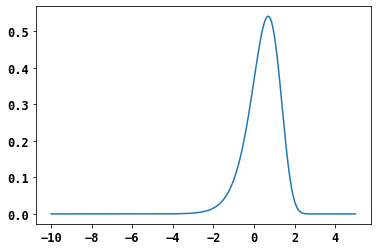

In [36]:
def pralpha_z(z, alpha):
    """
    z = log(Np)
    """
    return np.exp(z - np.exp(z))*(1 + alpha*(np.exp(z) - 1))

z = np.linspace(-10,5,1000)
praz = pralpha_z(z = z, alpha = 1)
plt.plot(z, praz)

In [37]:
sum((praz[1:])*(z[1:]-z[:-1]))

0.9999999989539036

In [38]:
compute_entropy(probs = np.exp(praz))

6.895114369022704

In [39]:
# calculate the cross entropy difference estimate
def compute_IPRK(probdict, pU, k, euler_const = 0.577):
    num_qubits = len(pU)
    iprk = 0
    for key, value in probdict.items():
        ind = int(key.split(" ")[0], 2) # indices of the bitstrings, have to split between qubits and classical bits
        iprk += np.abs(value* pU[ind] )**(k)
    return iprk
compute_IPRK(probdict = p_noisy, pU = pU_test, k = 2)

4.771063893150591e-13

In [40]:
import pandas as pd
ks = np.arange(2,11,2)
df_qs = pd.DataFrame(columns= ['alpha_dig', 'puexp', 'ninstance', 'num_qubits', 'depth', 'pU','entropy','cross_entropy', 'cross_entropy_diff','nshots']+['IPR%i'%k for k in ks])
df_qs

,alpha_dig,puexp,ninstance,num_qubits,depth,pU,entropy,cross_entropy,cross_entropy_diff,nshots,IPR2,IPR4,IPR6,IPR8,IPR10


In [41]:
# make list of entropy depth pairs
def entropy_vs_depth(df = df_qs, r = 0.0005, num_qubits = 15, depth_range = np.arange(20,30,2), Nshots = int(2e3), ninstances = 1, ks = None, plot_hist_NpU = False):
    N = 2**(num_qubits)
    
    # get backend and noise model for simulating real hardware
    backend = provider.get_backend('ibmq_lima')
    hardware_noise_model = NoiseModel.from_backend(backend)
    sim_real = QasmSimulator(method='density_matrix', noise_model=hardware_noise_model)
    qc = None
    for i in range(len(depth_range)):
        depth = depth_range[i]
        # generate the quantum circuit
        if qc is not None:
            del qc
        qc = gen_rqc(num_qubits=num_qubits, depth = depth)
        qc.save_statevector()
        
        # Create ideal simulator backend and transpile circuit
        sim_ideal = AerSimulator(method='statevector')
        
        #Design noise model

        # Error parameters
        rinit = r # error rate for initialisation of the qrc
        r1 = r/10 # gate 1 error rate
        r2 = r # gate 2 error rate
        g1 = num_qubits*depth # number of single qbit gates
        g2 = num_2gates(num_qubits = num_qubits, depth = depth) # number of 2-qbit gates
        rmes = r # error rate for measurements
        
        # Initialise the noise model
        designed_noise_model = noise.NoiseModel()
        
        # Construct the errors
        # bitflip error
        bit_flip = noise.pauli_error([('X', r), ('I', 1 - r)]) # construct bit-flip error
        
        # Depolarizing quantum errors
        error_1 = noise.depolarizing_error(r1, 1)
        error_2 = noise.depolarizing_error(r2, 2)
        depolnum = 4/(4-1)
        
        designed_noise_model.add_all_qubit_quantum_error(bit_flip, "reset")
        designed_noise_model.add_all_qubit_quantum_error(error_1, ['unitary'])
        designed_noise_model.add_all_qubit_quantum_error(error_2, ['cz'])
        designed_noise_model.add_all_qubit_quantum_error(bit_flip, "measure")
        #print(designed_noise_model)

        
        # t_qc_noisy = transpile(qc, sim_noise)
        
        # measure all qubits
        qc.measure_all()
        for ninstance in range(1,ninstances+1):
            print("circ ", ninstance)
        
            # get probabilites from ideal circuit
            result_ideal = sim_ideal.run(qc).result()
            state = result_ideal.get_statevector()
            pU = state.probabilities()

            # Create noisy simulator backend and transpile circuit
            sim_noise = AerSimulator(noise_model=designed_noise_model)
            qct = transpile(qc, sim_noise) # transpile for noisy basis gates
            # get noisy probabilites
            result_noisy = sim_noise.run(qct, shots=Nshots).result()
            probs_noisy = prob_getcounts(result = result_noisy, qc = qc)

            #compute pu(x^exp)
            puexp = get_puexp(probdict_noisy = probs_noisy, pU = pU)

            #compute entropy
            entropy = compute_entropy(probs = np.array(list(result_ideal.get_counts().values())) )

            #compute cross entropy and cross entropy difference
            crentropy_diff, crentropy = cross_entropy_est(probdict_noisy = result_noisy.get_counts(qc), pU = pU )
            #crentropy_diff0, crentropy0 = cross_entropy_est(probdict_noisy = result_ideal.get_counts(qc), pU = pU) # to check if the same answer is given for r = 0
            #print("crentropy_diff0-crentropy_diff", crentropy_diff0-crentropy_diff)
            # compute iprk
            IPR_k = [compute_IPRK(probdict = result_noisy.get_counts(qc), pU = pU, k = k) for k in ks]

            #compute alpha digital eq 19 in paper
            alpha_dig = alpha_digital(r = r, depth=depth, num_qubits = num_qubits)
            #append to output        
            #print([float(IPR_k[ik]) for ik in range(len(ks))])
            tempdf = pd.DataFrame([[alpha_dig, tuple(puexp), ninstance, num_qubits, depth, tuple(pU), r, 
                                    entropy, crentropy, crentropy_diff, Nshots] + [IPR_k[ik] for ik in range(len(ks))]], 
                                  columns= ['alpha_dig', 'puexp', 'ninstance', 'num_qubits', 'depth', 'pU', 'r',
                                            'entropy','cross_entropy', 'cross_entropy_diff','nshots']+ ['IPR%i'%k for k in ks])
            df = pd.concat([df, tempdf])
    return df

In [42]:
dfmaster = pd.DataFrame(columns= ['alpha_dig', 'puexp', 'ninstance', 'num_qubits', 'depth', 'pU','entropy','cross_entropy', 'cross_entropy_diff','nshots']+['IPR%i'%k for k in ks])
dfmaster

,alpha_dig,puexp,ninstance,num_qubits,depth,pU,entropy,cross_entropy,cross_entropy_diff,nshots,IPR2,IPR4,IPR6,IPR8,IPR10


In [45]:
depth_range = np.array(list(np.arange(5,20,1)) + [20,25,30,35,40]) #depths
rs = np.array([0.001 , 0.0005, 0.002 , 0.005 , 0.01, 0.02 ]) #error rates
Ninstances = 10
shape = rs.shape + (Ninstances,) + depth_range.shape
depth5, cross_entropy5, cross_entropy_diff5, IPRK5, entropy5 = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(rs.shape + (Ninstances,)+ ks.shape +depth_range.shape), np.zeros(shape)

for j in range(len(rs)):
    r = rs[j]
    print("r", r)

    df_qs = entropy_vs_depth(num_qubits = 15, Nshots = int(5e3), r = r, depth_range = depth_range, ks=ks, ninstances = Ninstances)
    dfmaster = pd.concat([dfmaster, df_qs])
dfmaster

r 0.001
circ  1
5000
nshots 0.9999999999999443
puexp> 0.00010864822775865745
num_qubits 15
number of unique samples drawn 3993 
tot number of possible samples 32768
circ  2
5000
nshots 0.9999999999999452
puexp> 0.00010984354017800248
num_qubits 15
number of unique samples drawn 3983 
tot number of possible samples 32768
circ  3
5000
nshots 0.9999999999999439
puexp> 0.00010874904930013883
num_qubits 15
number of unique samples drawn 4014 
tot number of possible samples 32768
circ  4
5000
nshots 0.9999999999999454
puexp> 0.0001078159603572377
num_qubits 15
number of unique samples drawn 3993 
tot number of possible samples 32768
circ  5
5000
nshots 0.9999999999999434
puexp> 0.00010733379802727905
num_qubits 15
number of unique samples drawn 4007 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999466
puexp> 0.00011045902282347005
num_qubits 15
number of unique samples drawn 3936 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999456
puexp> 0.000

circ  4
5000
nshots 0.9999999999999378
puexp> 6.589789783655641e-05
num_qubits 15
number of unique samples drawn 4306 
tot number of possible samples 32768
circ  5
5000
nshots 0.9999999999999375
puexp> 6.570938688684678e-05
num_qubits 15
number of unique samples drawn 4339 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999368
puexp> 6.375102286335141e-05
num_qubits 15
number of unique samples drawn 4324 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999375
puexp> 6.421669763139296e-05
num_qubits 15
number of unique samples drawn 4330 
tot number of possible samples 32768
circ  8
5000
nshots 0.9999999999999385
puexp> 6.466489787775754e-05
num_qubits 15
number of unique samples drawn 4302 
tot number of possible samples 32768
circ  9
5000
nshots 0.999999999999938
puexp> 6.519935551021274e-05
num_qubits 15
number of unique samples drawn 4319 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999366
puexp> 6.478101254498621e

5000
nshots 0.9999999999999337
puexp> 5.8864134368199e-05
num_qubits 15
number of unique samples drawn 4402 
tot number of possible samples 32768
circ  8
5000
nshots 0.9999999999999362
puexp> 6.0274068546341305e-05
num_qubits 15
number of unique samples drawn 4343 
tot number of possible samples 32768
circ  9
5000
nshots 0.9999999999999349
puexp> 5.921665005134203e-05
num_qubits 15
number of unique samples drawn 4397 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999349
puexp> 5.877524654415507e-05
num_qubits 15
number of unique samples drawn 4406 
tot number of possible samples 32768
circ  1
5000
nshots 0.9999999999999348
puexp> 5.8037980057613596e-05
num_qubits 15
number of unique samples drawn 4408 
tot number of possible samples 32768
circ  2
5000
nshots 0.9999999999999352
puexp> 5.816130553584745e-05
num_qubits 15
number of unique samples drawn 4389 
tot number of possible samples 32768
circ  3
5000
nshots 0.9999999999999343
puexp> 5.768303927870465e-05
num

5000
nshots 0.9999999999999343
puexp> 5.724057256045767e-05
num_qubits 15
number of unique samples drawn 4404 
tot number of possible samples 32768
circ  1
5000
nshots 0.9999999999999342
puexp> 5.663721571658058e-05
num_qubits 15
number of unique samples drawn 4399 
tot number of possible samples 32768
circ  2
5000
nshots 0.9999999999999353
puexp> 5.583171045213039e-05
num_qubits 15
number of unique samples drawn 4402 
tot number of possible samples 32768
circ  3
5000
nshots 0.9999999999999334
puexp> 5.539666336828511e-05
num_qubits 15
number of unique samples drawn 4461 
tot number of possible samples 32768
circ  4
5000
nshots 0.9999999999999349
puexp> 5.508634280610055e-05
num_qubits 15
number of unique samples drawn 4418 
tot number of possible samples 32768
circ  5
5000
nshots 0.9999999999999346
puexp> 5.7220046290056895e-05
num_qubits 15
number of unique samples drawn 4425 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999354
puexp> 5.6447950077399223e-05
nu

5000
nshots 0.9999999999999434
puexp> 8.324865393684399e-05
num_qubits 15
number of unique samples drawn 4099 
tot number of possible samples 32768
circ  4
5000
nshots 0.9999999999999387
puexp> 8.355876173974972e-05
num_qubits 15
number of unique samples drawn 4175 
tot number of possible samples 32768
circ  5
5000
nshots 0.9999999999999417
puexp> 8.416277169827489e-05
num_qubits 15
number of unique samples drawn 4148 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999397
puexp> 8.298607638825948e-05
num_qubits 15
number of unique samples drawn 4177 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999402
puexp> 8.302616782104713e-05
num_qubits 15
number of unique samples drawn 4165 
tot number of possible samples 32768
circ  8
5000
nshots 0.9999999999999412
puexp> 8.49283695456629e-05
num_qubits 15
number of unique samples drawn 4167 
tot number of possible samples 32768
circ  9
5000
nshots 0.9999999999999403
puexp> 8.468108561828371e-05
num_q

5000
nshots 0.9999999999999376
puexp> 6.5052595823703e-05
num_qubits 15
number of unique samples drawn 4288 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999373
puexp> 6.428579733112538e-05
num_qubits 15
number of unique samples drawn 4319 
tot number of possible samples 32768
circ  8
5000
nshots 0.9999999999999362
puexp> 6.358583493520249e-05
num_qubits 15
number of unique samples drawn 4321 
tot number of possible samples 32768
circ  9
5000
nshots 0.9999999999999378
puexp> 6.500758894916374e-05
num_qubits 15
number of unique samples drawn 4318 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999353
puexp> 6.359576894918475e-05
num_qubits 15
number of unique samples drawn 4358 
tot number of possible samples 32768
circ  1
5000
nshots 0.9999999999999366
puexp> 6.213791961042253e-05
num_qubits 15
number of unique samples drawn 4355 
tot number of possible samples 32768
circ  2
5000
nshots 0.9999999999999369
puexp> 6.210196272412479e-05
num_q

5000
nshots 0.9999999999999372
puexp> 5.941535505312834e-05
num_qubits 15
number of unique samples drawn 4352 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999356
puexp> 6.023725240184582e-05
num_qubits 15
number of unique samples drawn 4361 
tot number of possible samples 32768
circ  1
5000
nshots 0.9999999999999368
puexp> 6.1360113840152e-05
num_qubits 15
number of unique samples drawn 4320 
tot number of possible samples 32768
circ  2
5000
nshots 0.9999999999999363
puexp> 6.026804001085393e-05
num_qubits 15
number of unique samples drawn 4387 
tot number of possible samples 32768
circ  3
5000
nshots 0.9999999999999345
puexp> 6.081727943070594e-05
num_qubits 15
number of unique samples drawn 4366 
tot number of possible samples 32768
circ  4
5000
nshots 0.9999999999999363
puexp> 5.958407681934331e-05
num_qubits 15
number of unique samples drawn 4368 
tot number of possible samples 32768
circ  5
5000
nshots 0.9999999999999364
puexp> 6.080685299892994e-05
num_q

5000
nshots 0.9999999999999342
puexp> 5.906602942650749e-05
num_qubits 15
number of unique samples drawn 4399 
tot number of possible samples 32768
circ  3
5000
nshots 0.9999999999999352
puexp> 5.871070883504428e-05
num_qubits 15
number of unique samples drawn 4404 
tot number of possible samples 32768
circ  4
5000
nshots 0.9999999999999343
puexp> 5.74007490653134e-05
num_qubits 15
number of unique samples drawn 4415 
tot number of possible samples 32768
circ  5
5000
nshots 0.9999999999999357
puexp> 5.941854339171846e-05
num_qubits 15
number of unique samples drawn 4372 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999346
puexp> 5.95389378542111e-05
num_qubits 15
number of unique samples drawn 4374 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999353
puexp> 5.8476286937782095e-05
num_qubits 15
number of unique samples drawn 4402 
tot number of possible samples 32768
circ  8
5000
nshots 0.9999999999999355
puexp> 5.9268737935906184e-05
num_

5000
nshots 0.9999999999999392
puexp> 7.595102946796184e-05
num_qubits 15
number of unique samples drawn 4231 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999386
puexp> 7.639779334345244e-05
num_qubits 15
number of unique samples drawn 4259 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999392
puexp> 7.626353935562315e-05
num_qubits 15
number of unique samples drawn 4213 
tot number of possible samples 32768
circ  8
5000
nshots 0.999999999999938
puexp> 7.48342068611158e-05
num_qubits 15
number of unique samples drawn 4265 
tot number of possible samples 32768
circ  9
5000
nshots 0.9999999999999377
puexp> 7.440487272564261e-05
num_qubits 15
number of unique samples drawn 4293 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999393
puexp> 7.428575425090582e-05
num_qubits 15
number of unique samples drawn 4257 
tot number of possible samples 32768
circ  1
5000
nshots 0.9999999999999349
puexp> 6.529563357089622e-05
num_q

5000
nshots 0.9999999999999366
puexp> 5.899817450931681e-05
num_qubits 15
number of unique samples drawn 4372 
tot number of possible samples 32768
circ  9
5000
nshots 0.9999999999999349
puexp> 5.775555955842262e-05
num_qubits 15
number of unique samples drawn 4401 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999368
puexp> 5.843394279975823e-05
num_qubits 15
number of unique samples drawn 4351 
tot number of possible samples 32768
circ  1
5000
nshots 0.9999999999999364
puexp> 5.782247540185318e-05
num_qubits 15
number of unique samples drawn 4391 
tot number of possible samples 32768
circ  2
5000
nshots 0.9999999999999346
puexp> 5.7406156872107114e-05
num_qubits 15
number of unique samples drawn 4428 
tot number of possible samples 32768
circ  3
5000
nshots 0.9999999999999334
puexp> 5.762704570902372e-05
num_qubits 15
number of unique samples drawn 4435 
tot number of possible samples 32768
circ  4
5000
nshots 0.9999999999999335
puexp> 5.776552825401599e-05
nu

5000
nshots 0.9999999999999339
puexp> 5.452546047680153e-05
num_qubits 15
number of unique samples drawn 4445 
tot number of possible samples 32768
circ  2
5000
nshots 0.9999999999999332
puexp> 5.413510703503309e-05
num_qubits 15
number of unique samples drawn 4457 
tot number of possible samples 32768
circ  3
5000
nshots 0.9999999999999342
puexp> 5.455559632185373e-05
num_qubits 15
number of unique samples drawn 4471 
tot number of possible samples 32768
circ  4
5000
nshots 0.999999999999933
puexp> 5.4537302469677834e-05
num_qubits 15
number of unique samples drawn 4471 
tot number of possible samples 32768
circ  5
5000
nshots 0.999999999999935
puexp> 5.443336889381454e-05
num_qubits 15
number of unique samples drawn 4444 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999334
puexp> 5.480091631567045e-05
num_qubits 15
number of unique samples drawn 4447 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999359
puexp> 5.4540716445963946e-05
num_

5000
nshots 0.9999999999999324
puexp> 5.0081003136123045e-05
num_qubits 15
number of unique samples drawn 4535 
tot number of possible samples 32768
circ  5
5000
nshots 0.9999999999999322
puexp> 5.019364956212846e-05
num_qubits 15
number of unique samples drawn 4492 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999333
puexp> 4.9978314734460446e-05
num_qubits 15
number of unique samples drawn 4485 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999316
puexp> 4.951852225007085e-05
num_qubits 15
number of unique samples drawn 4514 
tot number of possible samples 32768
circ  8
5000
nshots 0.9999999999999317
puexp> 4.883710298004393e-05
num_qubits 15
number of unique samples drawn 4531 
tot number of possible samples 32768
circ  9
5000
nshots 0.9999999999999333
puexp> 4.937374010126436e-05
num_qubits 15
number of unique samples drawn 4496 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999317
puexp> 4.9052922052246774e-05


5000
nshots 0.9999999999999344
puexp> 6.134729419765838e-05
num_qubits 15
number of unique samples drawn 4426 
tot number of possible samples 32768
circ  8
5000
nshots 0.9999999999999348
puexp> 6.108473901996133e-05
num_qubits 15
number of unique samples drawn 4394 
tot number of possible samples 32768
circ  9
5000
nshots 0.9999999999999347
puexp> 6.189598967180524e-05
num_qubits 15
number of unique samples drawn 4407 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999345
puexp> 6.186047047566932e-05
num_qubits 15
number of unique samples drawn 4393 
tot number of possible samples 32768
circ  1
5000
nshots 0.9999999999999337
puexp> 5.834468908473719e-05
num_qubits 15
number of unique samples drawn 4413 
tot number of possible samples 32768
circ  2
5000
nshots 0.9999999999999347
puexp> 5.750804499789802e-05
num_qubits 15
number of unique samples drawn 4426 
tot number of possible samples 32768
circ  3
5000
nshots 0.9999999999999336
puexp> 5.681232686014115e-05
num

5000
nshots 0.9999999999999337
puexp> 4.8951677933222003e-05
num_qubits 15
number of unique samples drawn 4507 
tot number of possible samples 32768
circ  1
5000
nshots 0.9999999999999322
puexp> 4.9602827449906184e-05
num_qubits 15
number of unique samples drawn 4517 
tot number of possible samples 32768
circ  2
5000
nshots 0.999999999999932
puexp> 4.896215191657395e-05
num_qubits 15
number of unique samples drawn 4527 
tot number of possible samples 32768
circ  3
5000
nshots 0.9999999999999314
puexp> 4.8573025118781625e-05
num_qubits 15
number of unique samples drawn 4540 
tot number of possible samples 32768
circ  4
5000
nshots 0.9999999999999334
puexp> 4.8545250017124717e-05
num_qubits 15
number of unique samples drawn 4505 
tot number of possible samples 32768
circ  5
5000
nshots 0.9999999999999303
puexp> 4.929575529352951e-05
num_qubits 15
number of unique samples drawn 4534 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999325
puexp> 4.906546249769794e-05
n

circ  3
5000
nshots 0.999999999999931
puexp> 4.662666984428574e-05
num_qubits 15
number of unique samples drawn 4563 
tot number of possible samples 32768
circ  4
5000
nshots 0.9999999999999304
puexp> 4.6549257892954893e-05
num_qubits 15
number of unique samples drawn 4557 
tot number of possible samples 32768
circ  5
5000
nshots 0.9999999999999314
puexp> 4.700474878731413e-05
num_qubits 15
number of unique samples drawn 4542 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999308
puexp> 4.748443851803577e-05
num_qubits 15
number of unique samples drawn 4569 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999313
puexp> 4.644879853014128e-05
num_qubits 15
number of unique samples drawn 4530 
tot number of possible samples 32768
circ  8
5000
nshots 0.9999999999999306
puexp> 4.639587914066548e-05
num_qubits 15
number of unique samples drawn 4549 
tot number of possible samples 32768
circ  9
5000
nshots 0.9999999999999313
puexp> 4.6170154029309544

5000
nshots 0.9999999999999305
puexp> 3.798198699436178e-05
num_qubits 15
number of unique samples drawn 4615 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999298
puexp> 3.782140777960234e-05
num_qubits 15
number of unique samples drawn 4625 
tot number of possible samples 32768
circ  8
5000
nshots 0.9999999999999297
puexp> 3.85677118238426e-05
num_qubits 15
number of unique samples drawn 4624 
tot number of possible samples 32768
circ  9
5000
nshots 0.9999999999999302
puexp> 3.9339298476031174e-05
num_qubits 15
number of unique samples drawn 4628 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999308
puexp> 3.85219029165494e-05
num_qubits 15
number of unique samples drawn 4605 
tot number of possible samples 32768
r 0.01
circ  1
5000
nshots 0.99999999999994
puexp> 9.182201703414812e-05
num_qubits 15
number of unique samples drawn 4205 
tot number of possible samples 32768
circ  2
5000
nshots 0.9999999999999402
puexp> 9.391817916518801e-05

5000
nshots 0.9999999999999314
puexp> 5.104436864008055e-05
num_qubits 15
number of unique samples drawn 4528 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999319
puexp> 5.010476259666852e-05
num_qubits 15
number of unique samples drawn 4531 
tot number of possible samples 32768
circ  1
5000
nshots 0.9999999999999314
puexp> 4.933913119602616e-05
num_qubits 15
number of unique samples drawn 4541 
tot number of possible samples 32768
circ  2
5000
nshots 0.9999999999999319
puexp> 4.9327397865146174e-05
num_qubits 15
number of unique samples drawn 4526 
tot number of possible samples 32768
circ  3
5000
nshots 0.9999999999999325
puexp> 4.777371203459207e-05
num_qubits 15
number of unique samples drawn 4524 
tot number of possible samples 32768
circ  4
5000
nshots 0.9999999999999318
puexp> 5.0452676118711586e-05
num_qubits 15
number of unique samples drawn 4532 
tot number of possible samples 32768
circ  5
5000
nshots 0.9999999999999324
puexp> 4.817042070247895e-05
n

5000
nshots 0.9999999999999312
puexp> 4.304269371534292e-05
num_qubits 15
number of unique samples drawn 4560 
tot number of possible samples 32768
circ  3
5000
nshots 0.9999999999999305
puexp> 4.2255143916520466e-05
num_qubits 15
number of unique samples drawn 4603 
tot number of possible samples 32768
circ  4
5000
nshots 0.9999999999999301
puexp> 4.050191279208691e-05
num_qubits 15
number of unique samples drawn 4604 
tot number of possible samples 32768
circ  5
5000
nshots 0.9999999999999297
puexp> 4.21843867313386e-05
num_qubits 15
number of unique samples drawn 4588 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999303
puexp> 4.106971206661237e-05
num_qubits 15
number of unique samples drawn 4617 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999302
puexp> 4.26936698190039e-05
num_qubits 15
number of unique samples drawn 4593 
tot number of possible samples 32768
circ  8
5000
nshots 0.9999999999999306
puexp> 4.1928681190977414e-05
num_

5000
nshots 0.9999999999999294
puexp> 3.821352298744034e-05
num_qubits 15
number of unique samples drawn 4644 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999293
puexp> 3.829139524888975e-05
num_qubits 15
number of unique samples drawn 4642 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999291
puexp> 3.760255413563331e-05
num_qubits 15
number of unique samples drawn 4636 
tot number of possible samples 32768
circ  8
5000
nshots 0.9999999999999291
puexp> 3.811177269779042e-05
num_qubits 15
number of unique samples drawn 4620 
tot number of possible samples 32768
circ  9
5000
nshots 0.9999999999999305
puexp> 3.803729748699917e-05
num_qubits 15
number of unique samples drawn 4602 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999304
puexp> 3.741124236404737e-05
num_qubits 15
number of unique samples drawn 4598 
tot number of possible samples 32768
circ  1
5000
nshots 0.9999999999999296
puexp> 3.582930566751317e-05
num

5000
nshots 0.9999999999999357
puexp> 7.887645111431635e-05
num_qubits 15
number of unique samples drawn 4345 
tot number of possible samples 32768
circ  9
5000
nshots 0.9999999999999367
puexp> 7.78729421591834e-05
num_qubits 15
number of unique samples drawn 4322 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999376
puexp> 7.844105642081654e-05
num_qubits 15
number of unique samples drawn 4330 
tot number of possible samples 32768
circ  1
5000
nshots 0.9999999999999328
puexp> 5.888432361817021e-05
num_qubits 15
number of unique samples drawn 4498 
tot number of possible samples 32768
circ  2
5000
nshots 0.9999999999999316
puexp> 5.864294997569158e-05
num_qubits 15
number of unique samples drawn 4494 
tot number of possible samples 32768
circ  3
5000
nshots 0.999999999999933
puexp> 5.8062239324739985e-05
num_qubits 15
number of unique samples drawn 4492 
tot number of possible samples 32768
circ  4
5000
nshots 0.9999999999999335
puexp> 5.7691296514505115e-05
num

5000
nshots 0.9999999999999302
puexp> 3.8169297176697604e-05
num_qubits 15
number of unique samples drawn 4596 
tot number of possible samples 32768
circ  2
5000
nshots 0.9999999999999309
puexp> 3.847759713432693e-05
num_qubits 15
number of unique samples drawn 4580 
tot number of possible samples 32768
circ  3
5000
nshots 0.9999999999999296
puexp> 3.906948564822702e-05
num_qubits 15
number of unique samples drawn 4605 
tot number of possible samples 32768
circ  4
5000
nshots 0.9999999999999301
puexp> 3.837432862645576e-05
num_qubits 15
number of unique samples drawn 4617 
tot number of possible samples 32768
circ  5
5000
nshots 0.9999999999999293
puexp> 3.974739757488853e-05
num_qubits 15
number of unique samples drawn 4606 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999301
puexp> 3.887350286703376e-05
num_qubits 15
number of unique samples drawn 4593 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999296
puexp> 3.904580811463998e-05
num

5000
nshots 0.9999999999999297
puexp> 3.3550165249679204e-05
num_qubits 15
number of unique samples drawn 4633 
tot number of possible samples 32768
circ  5
5000
nshots 0.9999999999999294
puexp> 3.348944966621193e-05
num_qubits 15
number of unique samples drawn 4640 
tot number of possible samples 32768
circ  6
5000
nshots 0.9999999999999294
puexp> 3.3373502460518444e-05
num_qubits 15
number of unique samples drawn 4650 
tot number of possible samples 32768
circ  7
5000
nshots 0.9999999999999294
puexp> 3.411542050046994e-05
num_qubits 15
number of unique samples drawn 4667 
tot number of possible samples 32768
circ  8
5000
nshots 0.9999999999999294
puexp> 3.426454856211877e-05
num_qubits 15
number of unique samples drawn 4640 
tot number of possible samples 32768
circ  9
5000
nshots 0.9999999999999297
puexp> 3.33124822208728e-05
num_qubits 15
number of unique samples drawn 4626 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999291
puexp> 3.4429252380927414e-05
n

5000
nshots 0.9999999999999291
puexp> 3.173758048148318e-05
num_qubits 15
number of unique samples drawn 4642 
tot number of possible samples 32768
circ  8
5000
nshots 0.9999999999999291
puexp> 3.1341706297292825e-05
num_qubits 15
number of unique samples drawn 4652 
tot number of possible samples 32768
circ  9
5000
nshots 0.9999999999999286
puexp> 3.16602206753284e-05
num_qubits 15
number of unique samples drawn 4656 
tot number of possible samples 32768
circ  10
5000
nshots 0.9999999999999301
puexp> 3.119232741403808e-05
num_qubits 15
number of unique samples drawn 4621 
tot number of possible samples 32768
circ  1
5000
nshots 0.999999999999929
puexp> 3.1725895220870557e-05
num_qubits 15
number of unique samples drawn 4646 
tot number of possible samples 32768
circ  2
5000
nshots 0.9999999999999298
puexp> 3.104425731512575e-05
num_qubits 15
number of unique samples drawn 4608 
tot number of possible samples 32768
circ  3
5000
nshots 0.9999999999999297
puexp> 3.1111811864685106e-05
nu

,alpha_dig,puexp,ninstance,num_qubits,depth,pU,entropy,cross_entropy,cross_entropy_diff,nshots,IPR2,IPR4,IPR6,IPR8,IPR10,r
0,1.000000,"(0.00011739958845184918, 1.3244359984477829e-0...",1,15,5,"(4.4837639107997405e-05, 9.90710632414126e-05,...",7.673786,9.534961,1.439247,5000,0.000240,4.478230e-10,2.424159e-15,1.714306e-20,1.343274e-25,0.00
0,1.000000,"(6.64188770782167e-06, 9.088770081243106e-05, ...",2,15,5,"(4.4837639107997405e-05, 9.90710632414126e-05,...",7.654032,9.529090,1.445118,5000,0.000255,4.214683e-10,1.560015e-15,7.455174e-21,4.085923e-26,0.00
0,1.000000,"(0.00026274815213292083, 0.0002940117085384442...",3,15,5,"(4.4837639107997405e-05, 9.90710632414126e-05,...",7.597880,9.508245,1.465963,5000,0.000338,2.513911e-09,6.513792e-14,2.225301e-18,8.190745e-23,0.00
0,1.000000,"(0.00032242549524850886, 9.495230513974288e-05...",4,15,5,"(4.4837639107997405e-05, 9.90710632414126e-05,...",7.675889,9.540315,1.433893,5000,0.000246,7.179613e-10,1.052808e-14,2.134531e-19,4.533138e-24,0.00
0,1.000000,"(0.00016854161003297408, 4.6720829322448835e-0...",5,15,5,"(4.4837639107997405e-05, 9.90710632414126e-05,...",7.628629,9.517757,1.456451,5000,0.000283,8.168832e-10,7.110833e-15,8.074384e-20,1.001354e-24,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.000611,"(1.0591778285459865e-05, 0.0003092252493419891...",6,15,40,"(1.638112602476907e-05, 6.545772644567027e-05,...",8.001493,10.943366,0.030842,5000,0.000011,2.266971e-13,1.991911e-20,3.511706e-27,7.603722e-34,0.02
0,0.000611,"(0.0003526843701796771, 9.591390494811239e-05,...",7,15,40,"(1.638112602476907e-05, 6.545772644567027e-05,...",7.989471,11.000593,-0.026386,5000,0.000010,1.924036e-13,1.139003e-20,1.125063e-27,1.357376e-34,0.02
0,0.000611,"(0.0006437594209150383, 1.3995086890624425e-05...",8,15,40,"(1.638112602476907e-05, 6.545772644567027e-05,...",8.006712,10.982344,-0.008137,5000,0.000010,1.430480e-13,4.917802e-21,2.560223e-28,1.616435e-35,0.02
0,0.000611,"(0.00039262501695922847, 0.0001436394506989645...",9,15,40,"(1.638112602476907e-05, 6.545772644567027e-05,...",7.987616,10.969725,0.004483,5000,0.000011,2.281279e-13,1.421319e-20,1.572554e-27,2.264988e-34,0.02


In [ ]:
dfmaster.to_csv('/home/IPP-HGW/joag/homework/db_qcqi_exam_5e3samples_5to19_20_40_step5_final')

In [ ]:
# compute the standard deviation of the database
def std_of_df(dfmaster):
    dfmaster_stds = pd.DataFrame(columns= ['alpha_dig', 'ninstance', 'num_qubits', 'depth', 'r',
                                            'entropy','cross_entropy', 'cross_entropy_diff','nshots']+ ['IPR%i'%k for k in np.arange(2,11,2)])
    for d in sorted(dfmaster['depth'].unique()):
        for r in sorted(dfmaster['r'].unique()):
            inds = dfmaster['r'].isin([r]) & dfmaster['depth'].isin([d])
            tdfm = dfmaster[inds].std()
            tempdf = pd.DataFrame([tdfm], columns= ['alpha_dig', 'ninstance', 'num_qubits', 'depth', 'r',
                                                'entropy','cross_entropy', 'cross_entropy_diff','nshots']+ ['IPR%i'%k for k in np.arange(2,11,2)])
            dfmaster_stds = pd.concat([dfmaster_stds, tempdf])
    return dfmaster_stds

In [ ]:
"""dfmaster_stds.to_csv('/home/IPP-HGW/joag/homework/db_qcqi_exam_std_5to19_20_40_step5')"""

In [ ]:
# compute the mean of the database without probabilites
def mean_of_df_noprobs(dfmaster):
    dfmaster_mean_noprobs = pd.DataFrame(columns= ['alpha_dig', 'ninstance', 'num_qubits', 'depth', 'r',
                                            'entropy','cross_entropy', 'cross_entropy_diff','nshots']+ ['IPR%i'%k for k in np.arange(2,11,2)])
    for d in sorted(dfmaster['depth'].unique()):
        for r in sorted(dfmaster['r'].unique()):
            inds = dfmaster['r'].isin([r]) & dfmaster['depth'].isin([d])

            tdfm = dfmaster[inds].mean()
            tempdf = pd.DataFrame([tdfm], columns= ['alpha_dig', 'puexp', 'ninstance', 'num_qubits', 'depth', 'pU', 'r',
                                                'entropy','cross_entropy', 'cross_entropy_diff','nshots']+ ['IPR%i'%k for k in np.arange(2,11,2)])
            dfmaster_mean_noprobs = pd.concat([dfmaster_mean_noprobs, tempdf])
    return dfmaster_mean_noprobs

In [ ]:
dfmaster_mean_noprobs.to_csv('/home/IPP-HGW/joag/homework/db_qcqi_exam_means_noprobs_5to19_20_40_step5')

In [ ]:
def mean_of_df(dfmaster):
    dfmaster_mean = pd.DataFrame(columns= ['alpha_dig', 'puexp', 'ninstance', 'num_qubits', 'depth', 'pU', 'r',
                                            'entropy','cross_entropy', 'cross_entropy_diff','nshots']+ ['IPR%i'%k for k in np.arange(2,11,2)])
    for d in sorted(dfmaster['depth'].unique()):
        for r in sorted(dfmaster['r'].unique()):
            inds = dfmaster['r'].isin([r]) & dfmaster['depth'].isin([d])
            pus = []
            puexps = []
            for i,row in dfmaster[['pU', 'puexp']].iterrows():
                puexps.append(np.array(list(row['puexp'])))
                pus.append(np.array(list(row['pU'])))
            tdfm = dfmaster[inds].mean()
            tdfm['pU'] = np.mean(np.array(pus), axis = 0)
            tdfm['puexp'] = np.array(puexps)
            tempdf = pd.DataFrame([tdfm], columns= ['alpha_dig', 'puexp', 'ninstance', 'num_qubits', 'depth', 'pU', 'r',
                                                'entropy','cross_entropy', 'cross_entropy_diff','nshots']+ ['IPR%i'%k for k in np.arange(2,11,2)])
            dfmaster_mean = pd.concat([dfmaster_mean, tempdf])
    return dfmaster_mean

In [ ]:
#dfmaster_mean.to_csv('/home/IPP-HGW/joag/homework/db_qcqi_exam_mean_5to19_20_40_step5')

In [ ]:
from matplotlib import cm
from matplotlib.colors import Normalize as clnormalize
num_qubit = max(dfmaster['num_qubits'].unique())
fig, ax = plt.subplots(figsize=(10,10))
viridis = cm.get_cmap('viridis', 20)
sm = cm.ScalarMappable(cmap=viridis, norm = clnormalize(dfmaster['r'].unique()[0], dfmaster['r'].unique()[-1]))
ind_d = dfmaster_mean_noprobs['depth'].isin([20, 25, 30, 35, 40])
for r in dfmaster_mean_noprobs['r'].unique():
    indr = dfmaster_mean_noprobs['r'].isin([r])
    items = dfmaster_mean_noprobs[['depth', 'cross_entropy_diff', 'alpha_dig']][indr&ind_d]
    line1 = ax.plot(items['depth'], items['cross_entropy_diff'], '-X', label = '$r_{est} = %.3f$'%r, c = viridis(r*50))
    line2 = ax.plot(items['depth'], items['alpha_dig'], '--o', label = '$r_{dig} = %.3f$'%r, c = viridis(r*50))
    ebar1 = ax.errorbar(items['depth'], items['cross_entropy_diff'],
                        yerr=dfmaster_stds['cross_entropy_diff'][indr&ind_d],ecolor = viridis(r*50), color = viridis(r*50))
plt.colorbar(sm)
plt.legend(loc='lower right')
plt.xlabel("Depth")
plt.ylabel("Fidelity")

In [ ]:
z = np.linspace(-10,5,100)
alphas = np.array([1, 0.43, 0.18, 0])
for alpha in alphas:
    praz = pralpha_z(z = z, alpha = alpha)
    plt.plot(z, praz)

In [ ]:
# for analytical expression of Porter Thomas distr
z = np.linspace(-8,4,1000)
colors = ['c', 'y', 'b', 'r', 'C1', 'C2']
depth = max(dfmaster['depth'].unique())
num_qubits = max(dfmaster['num_qubits'].unique())
print(num_qubits)
i = 0
plt.figure(figsize=(10,10))
rs = dfmaster['r'].unique()
rs.sort()

for r in rs:
    if r == 0.01:
        continue
    indr = dfmaster['r'].isin([r]) & dfmaster['depth'].isin([depth]) & dfmaster['num_qubits'].isin([num_qubits] )
    items = dfmaster[['puexp', 'cross_entropy_diff', 'pU', 'alpha_dig']][indr]
    meanpu = np.mean(np.array([np.array(list(tup)) for tup in items['pU']]), axis=0)
    # setting the last puexp as the measurement distribution because the number of samples drawn 
    #is not equal for each circuit drawn from the ensemble for which the sampling is done 
    lastpuexp = np.array(items['puexp'][[(i == 9) for i in range(10)]][0])
    
    #computing Np
    Np = 2**(num_qubits)*lastpuexp
    
    # computing log Np with redefinition for better numerics
    logNp = num_qubits*np.log(2) + np.log(lastpuexp)
    praz = pralpha_z(z = z, alpha = items['alpha_dig'].mean(axis=0))
    #print(items['cross_entropy_diff'])
    alpha_est = items['cross_entropy_diff'].mean(axis=0)
    alpha_dig = items['alpha_dig'].mean(axis=0)
    plt.hist(logNp, label='$\\alpha_{est} = %.2f$'%alpha_est, color = viridis(alpha_est), bins = 20, density = True, alpha=0.5 - 0.05*i)
    plt.plot(z, praz, '-', label = '$\\alpha_{dig} = %.2f}$'%alpha_dig, color = viridis(alpha_dig))#, np.exp(-logNp_ideal)
    plt.xlim(-5,3)
    i+=1
plt.legend()

In [ ]:
def compute_yaxis_iprk(df, k, num_qubits, ir):
    r  = df['r'].unique()[ir]
    print("r ", r)
    inds = df['r'].isin([r])
    #print(df['IPR%i'%k][inds])
    #print(iprkdf[indiprk]['IPR%i'%k])
    iprk = df['IPR%i'%k][inds]
    # for such a large number it is more convenient to use the logarithm
    lognumber = np.log(2**((k-1)*num_qubits)*iprk) - sum([np.log(i) for i in range(2,k+1)])
    return np.exp(lognumber), inds

In [ ]:
compute_yaxis_iprk(df = dfmaster_mean_noprobs, k = 2, num_qubits = max(dfmaster_mean_noprobs['num_qubits'].unique()), ir = 0)

In [ ]:
def iprkplot(depth, df, df_stds, ks = np.arange(2,11,2), ir= 1):
    plt.figure()
    num_qubits = max(df['num_qubits'].unique())
    for k in ks:
        iprk, inds = compute_yaxis_iprk(df = df, k = k, num_qubits = num_qubits, ir = ir)
        plt.plot(df['depth'][inds], iprk, '-o', label = '$k = %i$'%(k))
        plt.errorbar(df['depth'][inds], iprk, yerr = df_stds['IPR%i'%k][inds], label = '$k = %i$'%(k)) 
        #plt.ylim(0.99,5)
        plt.yscale('log')
        plt.xlabel("Depth")
        plt.ylabel("$IPRK^{(k)} N^{k-1}/k!$")
        
    plt.legend(loc='best')

In [ ]:
iprkplot(depth = np.arange(5, 20, 1), df = dfmaster_mean_noprobs, df_stds = dfmaster_stds)

In [ ]:
def paperplots(depth, ce, ced, e, r, df_std):
    title = "Mean value for $r = %.3f$"%r
    plt.figure()
    plt.title(title)
    plt.plot(depth, ce, '-ok')
    plt.errorbar(depth, ce, yerr = df_std['cross_entropy'])
    plt.xlabel("Depth")
    plt.ylabel("Mean cross-entropy")
    plt.savefig('/home/IPP-HGW/joag/homework/figures_qcqi_exam/cross_entropy_r_%.3f'%r + '.png')

    plt.figure()
    plt.title(title)
    plt.plot(depth, ced, '-ok')
    plt.errorbar(depth, ced, yerr = df_std['cross_entropy_diff'])
    plt.xlabel("Depth")
    plt.ylabel("Fidelity")
    plt.savefig('/home/IPP-HGW/joag/homework/figures_qcqi_exam/cross_entropy_diff_r_%.3f'%r + '.png')
    
    
    plt.figure()
    plt.title(title)
    plt.plot(depth, e, '-ok')
    #plt.plot(depth, np.ones(depth.shape)*(15*np.log(2)+ 0.577), '--r', label='$H(p_{uniform}))$')
    plt.plot(depth, np.ones(depth.shape)*(15*np.log(2)-1 + 0.577), '--r', label='$H(p_U))$')
    plt.errorbar(depth, e, yerr = df_std['entropy'])
    plt.xlabel("Depth")
    plt.ylabel("Mean entropy")
    plt.savefig('/home/IPP-HGW/joag/homework/figures_qcqi_exam/entropy_r_%.3f'%r + '.png')
    
    

In [ ]:
dfread = pd.read_csv('/home/IPP-HGW/joag/homework/db_qcqi_exam_final')


In [ ]:
dfread[['entropy']]

In [ ]:
mean_dfread = mean_of_df_noprobs(dfmaster=dfread)
mean_dfread

In [ ]:
stds_dfread = std_of_df(dfmaster=dfread)
stds_dfread

In [ ]:
mean_dfread[['depth', 'cross_entropy', 'r']]

In [ ]:
for r in sorted(mean_dfread['r'].unique()):
    print(r)
    indr = mean_dfread['r'].isin([r])
    cetest = mean_dfread['cross_entropy'][indr]
    cedtest = mean_dfread['cross_entropy_diff'][indr]
    etest = mean_dfread['entropy'][indr]
    paperplots(depth = mean_dfread['depth'].unique(), ce = cetest, ced = cedtest, e = etest, r = r, df_std = stds_dfread[indr])

In [ ]:
for r in sorted(dfmaster_mean_noprobs['r'].unique()):
    indr = dfmaster_mean_noprobs['r'].isin([r])
    cetest = dfmaster_mean_noprobs['cross_entropy'][indr]
    cedtest = dfmaster_mean_noprobs['cross_entropy_diff'][indr]
    etest = dfmaster_mean_noprobs['entropy'][indr]
    paperplots(depth = dfmaster_mean_noprobs['depth'].unique(), ce = cetest, ced = cedtest, e = etest, r = r, df_std = dfmaster_stds[indr])

In [ ]:
def add_error(atqubit,atdepth, ondepth, onqubit):
    return (atqubit == onqubit) & (atdepth == ondepth)

def gen_rqc_single_error(num_qubits, depth, errortype = 'x', add_error = add_error, atqubit = False, atdepth = False, operands = std_operands, seed = 2022):
    reg = [i for i in range(num_qubits)]
    random.seed(seed)
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h([i for i in range(qc.num_qubits)])
    choices = [None]*num_qubits
    for i in range(depth):
        # single-qubit gate layer
        for j in range(num_qubits):
            # print(i,j,add_error(atqubit = atqubit,atdepth = atdepth, ondepth = i, onqubit =j))
            choice = random_gate(num_qubits=1, operands = operands)
            while choice == choices[j]:
                choice = random_gate(num_qubits=1, operands = operands)
            choices[j] = choice # store to make sure the same gate does not get chosen two times consequtively
            qc.unitary(choice, [j], label = choice.label)
            if add_error(atqubit = atqubit,atdepth = atdepth, ondepth = i, onqubit =j):
                if errortype == 'x':
                    qc.x(atqubit)
                if errortype == 'z':
                    qc.z(atqubit)
                
        # 2-qubit gate layer
        if i%2 == 0:
            igate = np.arange(0,num_qubits-2, 2)
            for j in igate: 
                qc.cz(j, j+1)
        else:
            igate = np.arange(1,num_qubits-1, 2)
            for j in igate:
                qc.cz(j, j+1)
        qc.barrier()
                   
    return qc


In [ ]:
qrc3 = gen_rqc_single_error(num_qubits=3, depth = 3, atdepth=2, atqubit=2, errortype='z')
qrc3.draw()

In [ ]:
from itertools import product
def fig3(num_qubits, depth, Nshots = 1, errortype = 'x'):
    
    qc_ideal = gen_rqc(num_qubits=num_qubits, depth = depth)
    qc_ideal.save_statevector()
    
    # get probabilites from ideal circuit
    
    # Create ideal simulator backend and transpile circuit
    sim_ideal = AerSimulator()
    t_qc = transpile(qc_ideal, sim_ideal)
    result_ideal = sim_ideal.run(t_qc, shots=Nshots).result()
    state_ideal = result_ideal.get_statevector()
    pideal = state_ideal.probabilities()

    perror = np.zeros((num_qubits, depth, 2**num_qubits))
    for atqubit in np.arange(0,num_qubits,1):
        for atdepth in np.arange(0,depth, 1):
            # print(atqubit, atdepth)
            qc = gen_rqc_single_error(num_qubits=num_qubits, depth = depth, errortype = errortype, atdepth=atdepth, atqubit=atqubit)
            qc.save_statevector()
            
            
            t_qc_paulierror = transpile(qc, sim_ideal)
            
            
            
            # get probabilites from circuit with the one pauli error
            result_paulierror = sim_ideal.run(t_qc_paulierror, shots=Nshots).result()
            state_error = result_paulierror.get_statevector()
            perror[atqubit,atdepth] += state_error.probabilities()
        
    # sorting
    # print(pideal.shape)
    # print(np.mean(perror, axis=0).shape)
    # print(np.mean(np.mean(perror, axis=0), axis=0))
    psorted = [pipe for pipe in zip(*sorted(zip(list(pideal), list(np.mean(np.mean(perror, axis=0), axis=0)))))]
    
    return psorted

In [ ]:
psortx = fig3(10,10)

In [ ]:
plt.title("Used X-gate for Pauli error")
plt.plot(np.arange(0,len(psortx[0]), 1), list(psortx[0]), label='No errors')
plt.plot(np.arange(0,len(psortx[0]), 1), list(psortx[1]), label='One Pauli error(averaged)')
plt.xlabel('Bit-string index $j (p(x_j)$-ordered)')
plt.ylabel('$Np$')
plt.legend(loc='best')

In [ ]:
psortz = fig3(10,10, errortype='z')

In [ ]:
plt.title("Used Z-gate for Pauli error")
plt.plot(np.arange(0,len(psortz[0]), 1), list(psortz[0]), label='No errors')
plt.plot(np.arange(0,len(psortz[0]), 1), list(psortz[1]), label='One Pauli error(averaged)')
plt.xlabel('Bit-string index $j (p(x_j)$-ordered)')
plt.ylabel('$Np$')
plt.legend(loc='best')